# Explore here

In [118]:
import seaborn as sns
import pandas as pd


total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [119]:
total_data.shape

(366, 2)

In [120]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [121]:
total_data["date"] = pd.to_datetime(total_data["date"])
total_data.set_index("date", inplace=True)
sales_df = total_data.resample("D").sum()
sales_df.ffill(inplace=True)
display(sales_df.head())

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

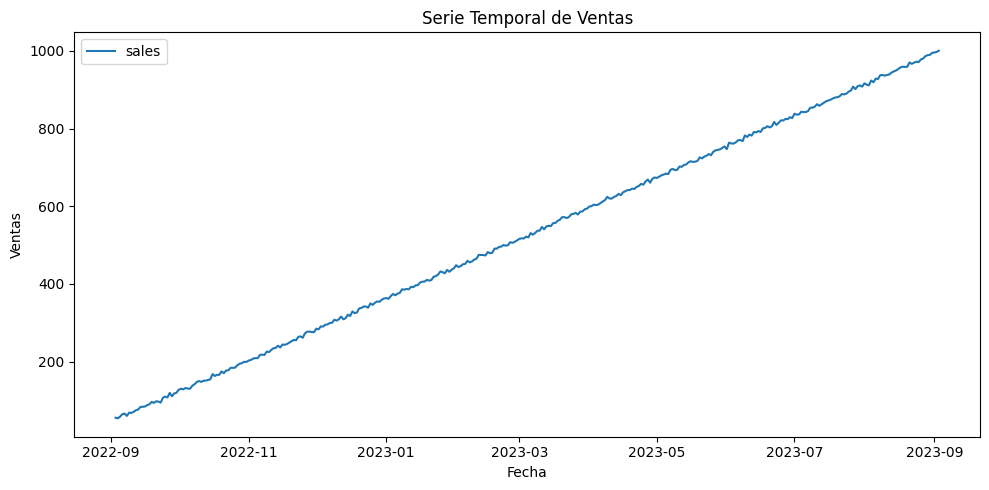

In [122]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = sales_df)
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.tight_layout()
plt.show()

La grafica de la serie temporal de ventas muestra una clara tendencia ascendente a lo largo del tiempo. se observan algunas fluctuaciones y posibles patrones repetitivos, lo que podria indicar estacionalidad, la tendencia general es de crecimiento constante.

Análisis de una serie tempora

Descomposición de la serie

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales_df, period = 12)
decomposition

Análisis de la tendencia

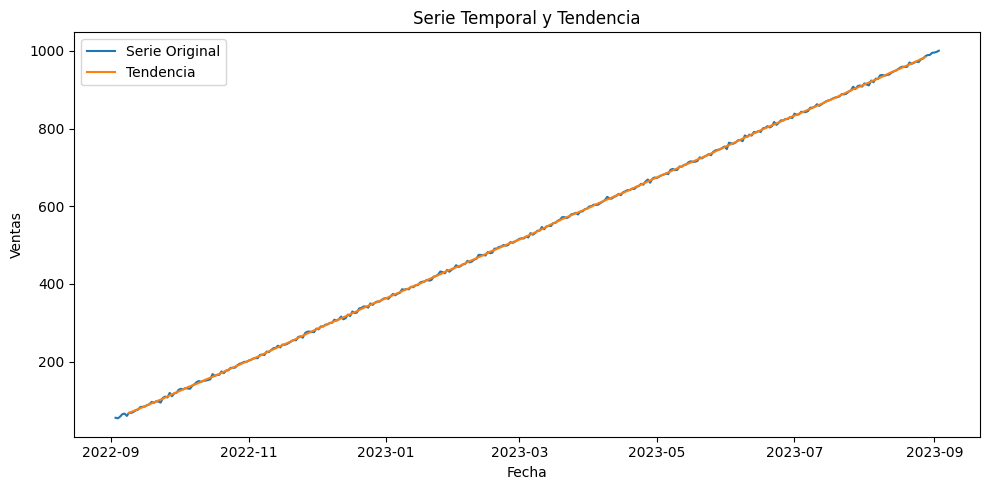

In [124]:
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (10, 5))
plt.plot(sales_df.index, sales_df['sales'], label='Serie Original')
plt.plot(trend.index, trend, label='Tendencia')
plt.title('Serie Temporal y Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

La gráfica de tendencia confirma la clara tendencia ascendente observada en la visualización inicial.

Análisis de la estacionalidad

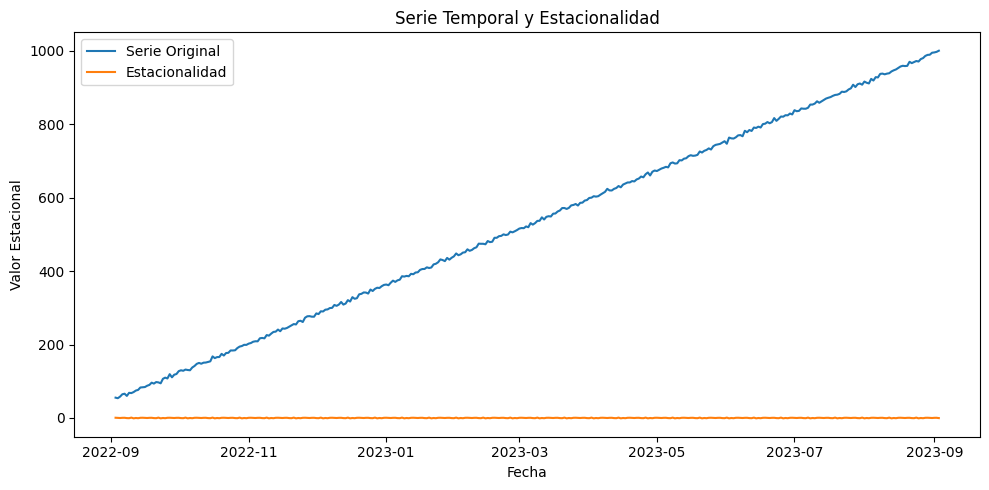

In [125]:
seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (10, 5))
plt.plot(sales_df.index, sales_df['sales'], label='Serie Original')
plt.plot(seasonal.index, seasonal, label='Estacionalidad')
plt.title('Serie Temporal y Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Valor Estacional')
plt.legend()
plt.tight_layout()
plt.show()

La componente estacional es muy pequeña en comparación con la tendencia, lo que sugiere que no hay un patrón estacional fuerte

In [126]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Estadístico de Prueba", "Valor p", "#Rezago Usados", "Número de Observaciones Usadas"])
    for key,value in dftest[4].items():
        dfoutput["Valor Crítico (%s)"%key] = value
    return dfoutput

# Realizar la prueba de estacionariedad en la serie original
print("Prueba de estacionariedad en la serie original:")
display(test_stationarity(sales_df['sales'])) # Pasamos solo la columna de ventas

Prueba de estacionariedad en la serie original:
Resultados de la prueba de Dickey-Fuller:


Estadístico de Prueba               0.545414
Valor p                             0.986190
#Rezago Usados                     13.000000
Número de Observaciones Usadas    352.000000
Valor Crítico (1%)                 -3.449065
Valor Crítico (5%)                 -2.869786
Valor Crítico (10%)                -2.571163
dtype: float64

Análisis de la variabilidad

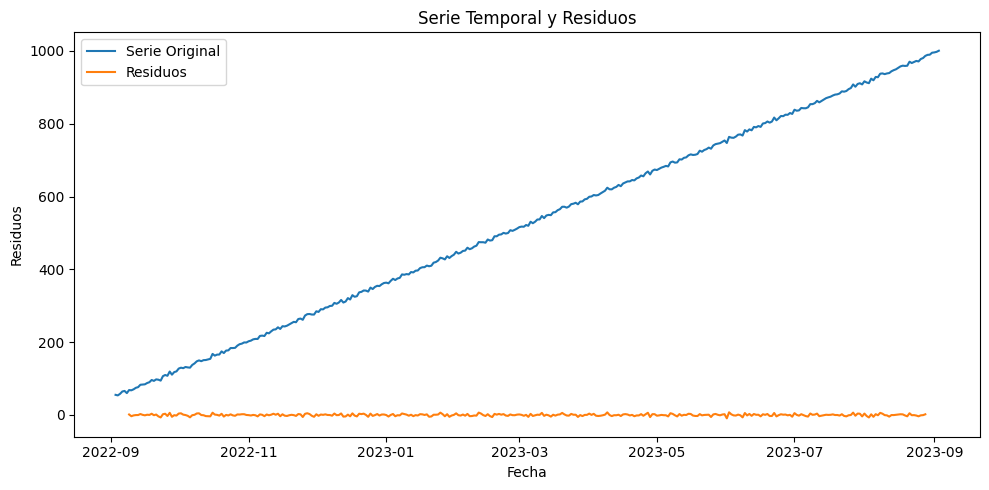

In [127]:
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))
plt.plot(sales_df.index, sales_df['sales'], label='Serie Original')
plt.plot(residual.index, residual, label='Residuos')
plt.title('Serie Temporal y Residuos')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.legend()
plt.tight_layout()
plt.show()

Los residuos representan la parte de la serie que no puede ser explicada por la tendencia o la estacionalidad. Muestran variaciones aleatorias alrededor de cero, indicando la presencia de ruido en los datos.

Análisis de la autocorrelación

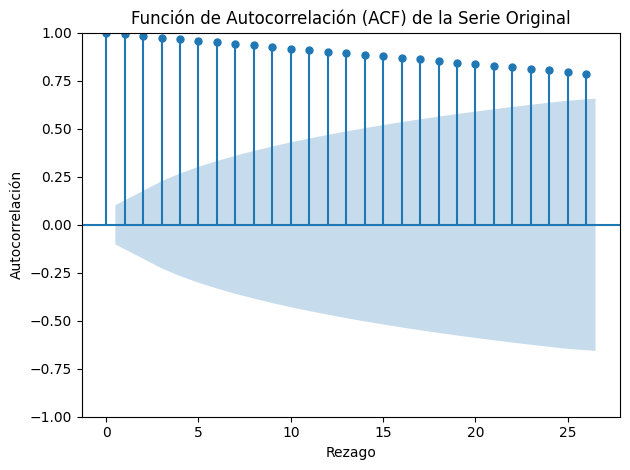

In [128]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales_df['sales'])
plt.title('Función de Autocorrelación (ACF) de la Serie Original')
plt.xlabel('Rezago')
plt.ylabel('Autocorrelación')
plt.tight_layout()
plt.show()

La grafica de ACF nos muestra la correlacion de la serie con sus versiones desplazadas en el tiempo, un decaimiento lento de la autocorrelación sugiere no estacionalidad y/o tendencia. 

¿Cuál es el tensor de la serie temporal? En este contexto, el "tensor" se refiere a la estructura de datos que representa la serie temporal. Después de la preparación, es un DataFrame de pandas (sales_ts) con la fecha como índice y una columna llamada 'sales' que contiene los valores de ventas agregados diariamente. 

¿Cuál es la tendencia? La tendencia de la serie temporal es claramente ascendente. Las ventas muestran un incremento general a lo largo del tiempo. 

¿Es estacionaria? La serie temporal original no es estacionaria (su prueba Dickey-Fuller tuvo un Valor p alto). Sin embargo, la serie temporal diferenciada sí es estacionaria (su prueba Dickey-Fuller tuvo un Valor p muy bajo). 

¿Existe variabilidad o presencia de ruido? Sí, existe variabilidad o ruido. Se observa en los residuos de la descomposición y en la gráfica de autocorrelación (ACF), que muestra fluctuaciones aleatorias y patrones no explicados por la tendencia y estacionalidad.

Entrenamiento del modelo

In [129]:
ts_stationary = sales_df['sales'].diff().dropna()

print("\nPrueba de estacionariedad en la serie diferenciada:")
display(test_stationarity(ts_stationary))


Prueba de estacionariedad en la serie diferenciada:
Resultados de la prueba de Dickey-Fuller:


Estadístico de Prueba            -9.430263e+00
Valor p                           5.212954e-16
#Rezago Usados                    1.200000e+01
Número de Observaciones Usadas    3.520000e+02
Valor Crítico (1%)               -3.449065e+00
Valor Crítico (5%)               -2.869786e+00
Valor Crítico (10%)              -2.571163e+00
dtype: float64

In [130]:
train_data = sales_df[:-30] 
test_data = sales_df[-30:] 

print("Tamaño del conjunto de entrenamiento:", train_data.shape)
print("Tamaño del conjunto de prueba:", test_data.shape)

Tamaño del conjunto de entrenamiento: (336, 1)
Tamaño del conjunto de prueba: (30, 1)


Entrenamiento del modelo ARIMA

In [131]:
from pmdarima import auto_arima

model = auto_arima(train_data, seasonal = True, m = 7, trace = True, error_action = 'ignore', suppress_warnings = True)


print("\nResumen del modelo ARIMA:")
display(model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1698.890, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1933.617, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1816.472, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2035.035, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=1696.276, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=1698.369, Time=0.40 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=1696.643, Time=1.87 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=1695.475, Time=1.09 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=1696.463, Time=1.59 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=1695.027, Time=1.83 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=1697.461, Time=1.88 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(3,1,2)(2,0,1)[7] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  336
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                -840.748
Date:                            Tue, 26 Aug 2025   AIC                           1691.495
Time:                                    17:41:49   BIC                           1710.566
Sample:                                09-03-2022   HQIC                          1699.098
                                     - 08-04-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3846      0.212     11.226      0.000       1.968       2.801
ar.L1         -0.0803      0.054     -1.481      0.139      -0.187       0.026
ma.L1         -0.9599      0.018    -52.902      0.000      -0.996      -0.924
ar.S.L7        0.1501      0.056      2.671      0.008       0.040       0.260
sigma2         8.7999      0.714     12.322      0.000       7.400      10.200
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.99   Prob(JB):                         0.80
Heteroskedasticity (H):               0.84   Skew:                             0.07
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prediccion con el Conjunto de Prueba

In [132]:
n_periods = len(test_data)
forecast_ARIMA = model.predict(n_periods = n_periods)

forecast_ARIMA = pd.Series(forecast_ARIMA, index = test_data.index)

print("\nPredicciones del modelo ARIMA para el conjunto de prueba:")
display(forecast_ARIMA.head())


Predicciones del modelo ARIMA para el conjunto de prueba:


date
2023-08-05    924.158347
2023-08-06    926.902474
2023-08-07    928.609678
2023-08-08    932.092793
2023-08-09    933.809255
Freq: D, dtype: float64

Comparacion de Predicciones y Valores Reales

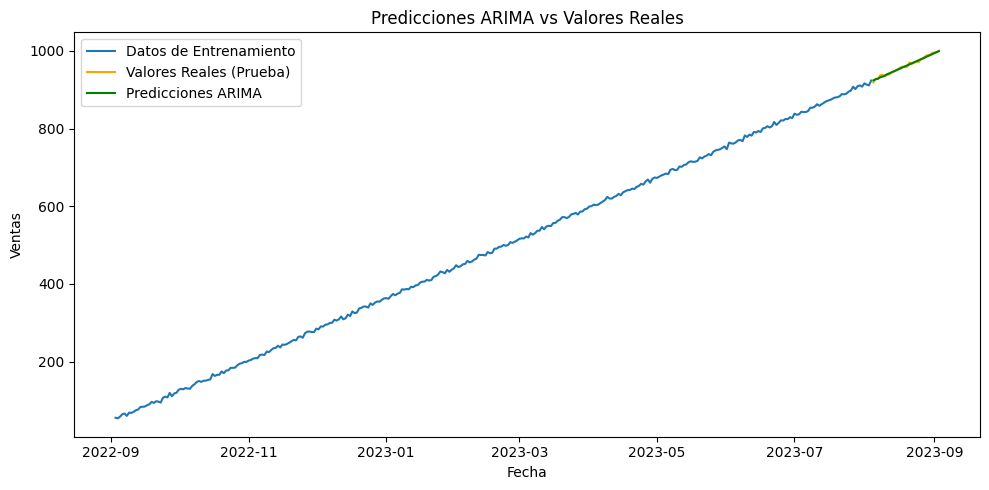

In [133]:
fig, axis = plt.subplots(figsize = (10, 5))
plt.plot(train_data.index, train_data['sales'], label='Datos de Entrenamiento')
plt.plot(test_data.index, test_data['sales'], label='Valores Reales (Prueba)', color='orange')
plt.plot(forecast_ARIMA.index, forecast_ARIMA, label='Predicciones ARIMA', color='green')
plt.title('Predicciones ARIMA vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

Vista mas cercana del grafico de comparacion

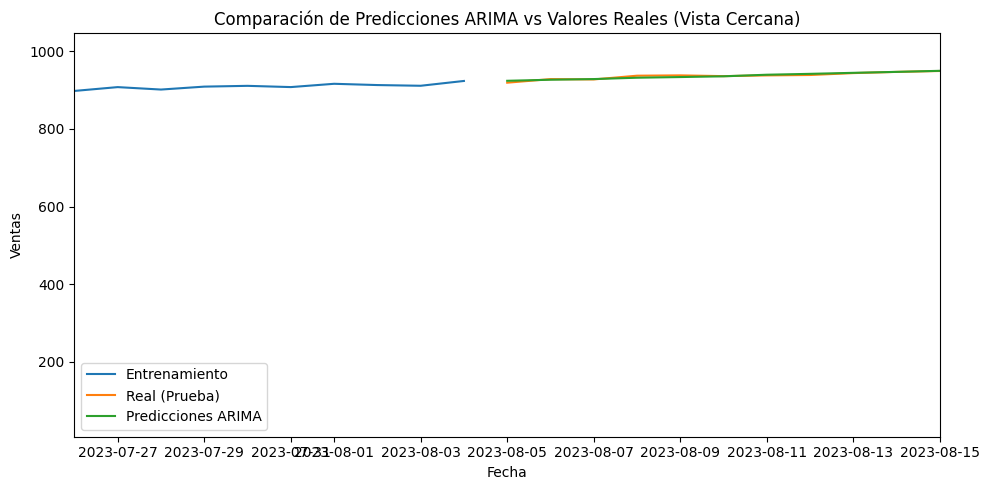

In [ ]:
plot_data = pd.concat([train_data.rename(columns={'sales': 'Ventas'}).assign(Tipo='Entrenamiento'),
                       test_data.rename(columns={'sales': 'Ventas'}).assign(Tipo='Real (Prueba)'),
                       forecast_ARIMA.rename('Ventas').to_frame().assign(Tipo='Predicciones ARIMA')])

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = plot_data, x=plot_data.index, y='Ventas', hue='Tipo')


start_date = train_data.index[-10]  
end_date = test_data.index[10]    
plt.xlim(start_date, end_date)


plt.title('Comparación de Predicciones ARIMA vs Valores Reales (Vista Cercana)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

Conclucion: Entrenamos un modelo ARIMA con auto_arima usando los datos de entrenamiento. El modelo hizo predicciones para el conjunto de prueba que siguieron la tendencia y estacionalidad de los datos reales, ofreciendo un pronostico razonable.